In [1]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time
from tifffile import tifffile
import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to CPU


In [2]:
save_folder = "/content/drive/MyDrive/Research/Quanvolution"

# MNIST

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13642581.07it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490088.62it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4541637.07it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2663292.15it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



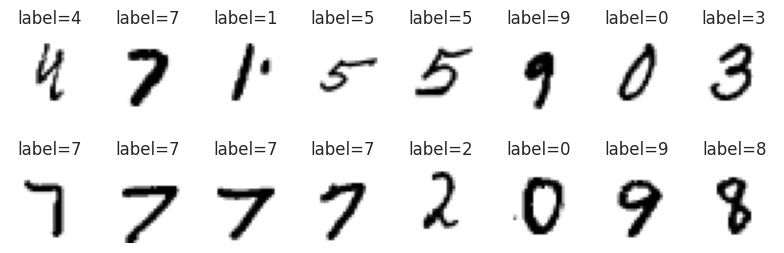

In [3]:
#from torchvision import datasets, transforms
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Step 2: Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Step 3: Display the images
# Choose how many images you want to display
n_images = 16

# Set up the figure size
fig = plt.figure(figsize=(8,3))

# Display images in a grid
for idx in range(n_images):
    plt.subplot(2,8, idx+1)  # Adjust the grid size based on your choice of n_images
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')
    plt.title(f"label={labels[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
fig.savefig(os.path.join(save_folder, 'mnist.pdf'))

# FashionMNIST


100%|██████████| 26421880/26421880 [00:02<00:00, 11867328.43it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199474.20it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3631748.32it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18144770.58it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



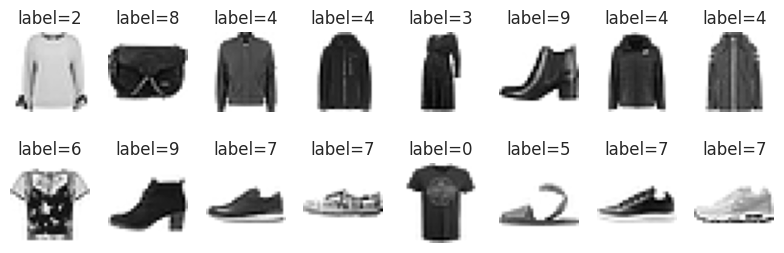

In [6]:
#from torchvision import datasets, transforms
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Step 2: Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Step 3: Display the images
# Choose how many images you want to display
n_images = 16

# Set up the figure size
fig = plt.figure(figsize=(8,3))

# Display images in a grid
for idx in range(n_images):
    plt.subplot(2, 8, idx+1)  # Adjust the grid size based on your choice of n_images
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')
    plt.title(f"label={labels[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
fig.savefig(os.path.join(save_folder, 'fashion-mnist.pdf'))

# CIFAR10

Files already downloaded and verified


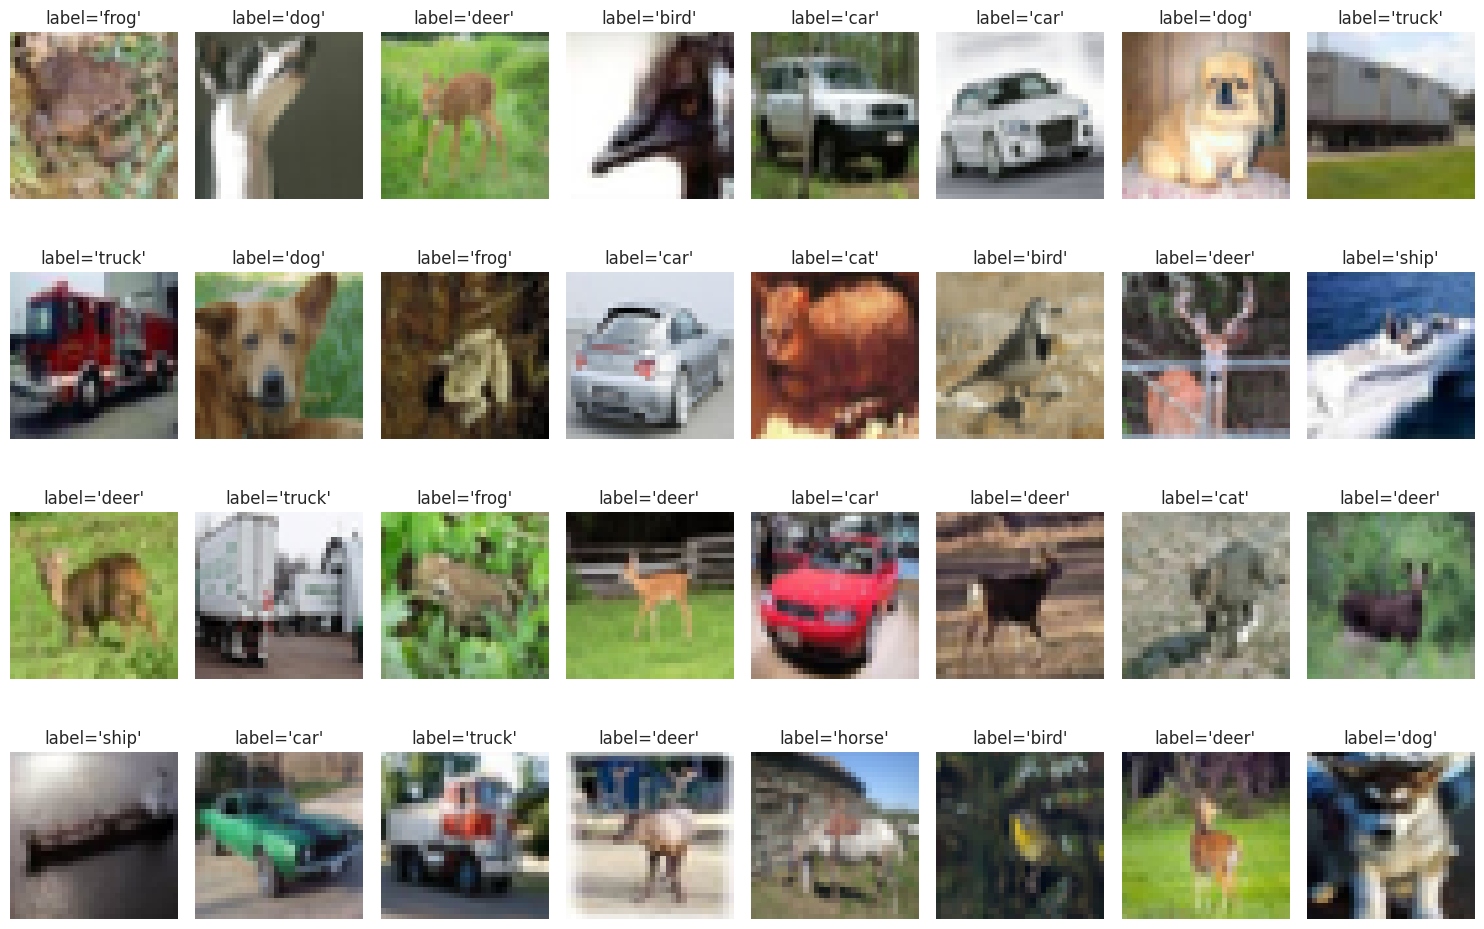

In [22]:
#from torchvision import datasets, transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5,), (0.5,))
                                ])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Step 2: Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Step 3: Display the images
# Choose how many images you want to display
n_images = 32
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Set up the figure size
fig = plt.figure(figsize=(15,10))

# Display images in a grid
for idx in range(n_images):
    plt.subplot(4, 8, idx+1)  # Adjust the grid size based on your choice of n_images
    npimg = images[idx].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"label='{classes[labels[idx].item()]}'")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
fig.savefig(os.path.join(save_folder, 'cifar10.pdf'))